# <center>What's in my water? - <br>Assessing water quality in the high elevation lakes of the Rocky Mountains, CO</center>
#### Maeve McCormick, advised by Chuck Rhoades and Tim Fegel <br> US Forest Service Rocky Mountain Research Station <br> for CU Boulder Earth Lab, Earth Analytics Applications Course, Summer, 2021 <br> <br> Keywords: aquatic chemistry, drought, alpine limnology, water quality, timeseries trends
***

In [1]:
%%capture
import os
import warnings

import folium
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import numpy as np
import pandas as pd

import contextily as ctx
import earthpy as et
import geopandas as gpd
import rasterio as rio
import seaborn as sns

# Import custom functions module
import functions_for_lakechem as flc

# Suppress simple warnings
warnings.simplefilter('ignore')

'''
A note on downloading the data : 
As this is research in its preliminary stages, the data are not yet publicly
available. A working version of the data are shared in the github repository.
The subset of the data represents 15 of the 43 lakes surveyed.

Please additionally note these data have a gap from 2012-2016 due to sampling
difficulties and a lapse in analytic equipment availability.
'''

# Define a variable for the working directory path.
wd_path = os.path.join(et.io.HOME,
                       "earth-analytics",
                       "alpine-lake-chemistry")
# Set the working directory or make the directory if it does not already exist.
if os.path.exists(wd_path):
    os.chdir(wd_path)
    print("The current working directory is", wd_path)
else:
    os.makedirs(wd_path)
    os.chdir(wd_path)
    print("The path does not exist but is being created")

In [2]:
%%capture
# Create file paths
fig_path = os.path.join('figures')
lakeproj_path = os.path.join('data')
lakechem_path = os.path.join(lakeproj_path,
                             'longterm-lake-chemistry-R2-subset.csv')
lakegeo_path = os.path.join(lakeproj_path,
                            'lakes_geotype.csv')
state_bounds_path = os.path.join(lakeproj_path,
                                 'TIGER2018',
                                 'STATE',
                                 'tl_2018_us_state.shp')

# Open lake chemistry file as a pandas dataframe, indexing by date.
# Clean up some column names and remove trailing whitespace.
lakechem_all = pd.read_csv(lakechem_path,
                           parse_dates=['date'],
                           index_col=['date'],
                           na_values=['NaN']) 

lakechem_all = lakechem_all.rename(columns={'site-rename': 'site_name'})
lakechem_all['site_name'] = lakechem_all['site_name'].str.rstrip()

# Open the lake geology data and join it to the lakechem dataframe.
lakegeo_all = pd.read_csv(lakegeo_path, index_col=['site_name'])
lakechem_all = lakechem_all.join(lakegeo_all, on='site_name')

# Generate a cleaner gdf for plotting from the coordinates in lakechem_all.
lake_coords = flc.pull_coords(source_df=lakechem_all, site_ID='site_name',
                              lat_col='LAT', long_col='LONG', crs='EPSG:4326')

# Open state boundary shapefiles and select only the states in Ecoregion 2 for
# which longterm data exists.
state_bounds = gpd.read_file(state_bounds_path)
states = ['CO']
state_bounds = state_bounds.loc[state_bounds['STUSPS'].isin(states)]

# Optional: take a look!
# lakechem_all.head()
# lake_coords.head()
# state_bounds.head()
# lakegeo_all.head()

In [3]:
# Filter for parameters of interest by dropping unused columns.
lakechem_subset = lakechem_all.drop(['national-forest', 'wilderness-area',
                                     'LAT', 'LONG', 'UTME', 'UTMN', 'ZONE',
                                     'time', 'monitoring-site-name',
                                     'COMMENT', 'rock_descriptor'], axis=1)

# Filter by geology type and group by lake name.
ig_lakes = lakechem_subset.loc[lakechem_subset['broad_type'] == 'igneous']
sed_lakes = lakechem_subset.loc[lakechem_subset['broad_type'] == 'sedimentary']
meta_lakes = lakechem_subset.loc[lakechem_subset['broad_type'] == 'metamorphic']
ig_by_lake = ig_lakes.groupby(['site_name'])
sed_by_lake = sed_lakes.groupby(['site_name'])
meta_by_lake = meta_lakes.groupby(['site_name'])

# Optional : take a look!
# lakechem_subset.head()

In [7]:
# Create dictionaries for custom colormapping and markers in plotting.
lch_site_grp = lakechem_subset.groupby(['site_name'])
lch_geo_grp = lakechem_subset.groupby(['broad_type'])

lakenames = np.concatenate(
    sorted(lch_site_grp['site_name'].unique())).ravel()
geotypes = np.concatenate(
    sorted(lch_geo_grp['broad_type'].unique())).ravel()

colors1 = sns.color_palette("gist_ncar_r", n_colors=len(lakenames))
colors2 = sns.color_palette('gist_earth', n_colors=len(geotypes))

color_dict_lakes = dict(zip(lakenames, colors1))
color_dict_geo = dict(zip(geotypes, colors2))
markers1 = ['s', '^', 'o']

# Prettier plotting with seaborn (set plot theme)
sns.set_context("talk")
sns.set_style("darkgrid", {'axes.facecolor': '#d7d7e0', "font.family": "serif"})

## Feeling Thirsty?
***
Water is *the most* vital resource supporting life on Earth. Alpine, or high-elevation, watersheds are extremely valuable and vulnerable sources of freshwater in the Western United States. Alpine lakes are particularly important because they protect downstream water quality by storing nutrients (ions and natural compounds like salts, calcium, and ammonium). However, excessive accumulation of nutrients limits the lakes' natural ability to serve as buffers. If the nutrient balance in a lake is upset, the *acid neutralization capacity (ANC)* of a lake might change. ANC determines the amount of an acidic substance needed to change the pH of a volume of water. In other words, changes to ANC affect how salty (alkaline) or acidic a lake becomes. Such changes have long-term consequences for water quality, and directly affect the communities that rely on alpine sources of freshwater. <br>

This issue is especially important as communities in the Western US grow. Population growth strains freshwater systems by increasing demand for use and exposure to pollution from agriculture and other human sources. Pollutants from human activities, such as nitrates, phosphates, and sulfates, accumulate in freshwater due to acid rain and snowfall, and affect nutrient balance and ANC. It is absolutely vital that the communities dependent on these vulnerable water resources implement management strategies to protect the environment and ensure communities in the west safely and sustainably persist. <br>

### In order to inform such water management strategies, my research used a long term survey of lake chemistry in Colorado to ask two main questions: 
* **Does geology affect baseline nutrient levels in alpine lakes?**
* **How is alpine lake chemistry (and water quality) changing over time?**

## Barkeep! A shot of...water? on the Rocks.
***
Wait. Geology!? What do rocks have to do with water quality? ***More than you think!* ~**<br> <br>
I mentioned that ions and chemical compounds can end up in lakes due to acid precipitation, but that isn't the only input sources of ions in lakes. Rocks weather and break down over time, releasing minerals and natural chemical compounds in the process. Different types of rock yield different compounds at different rates. Limestone contains more calcium than granite, for instance. To determine the affect of geology on nutrient levels, I categorized each lake into the three broad categories of rock: igneous, sedimentary, and metamorphic.

## Where am I, again?
***
The data I analyzed are for lakes in the Rocky Mountains of Colorado. You can see their locations plotted on the map below:

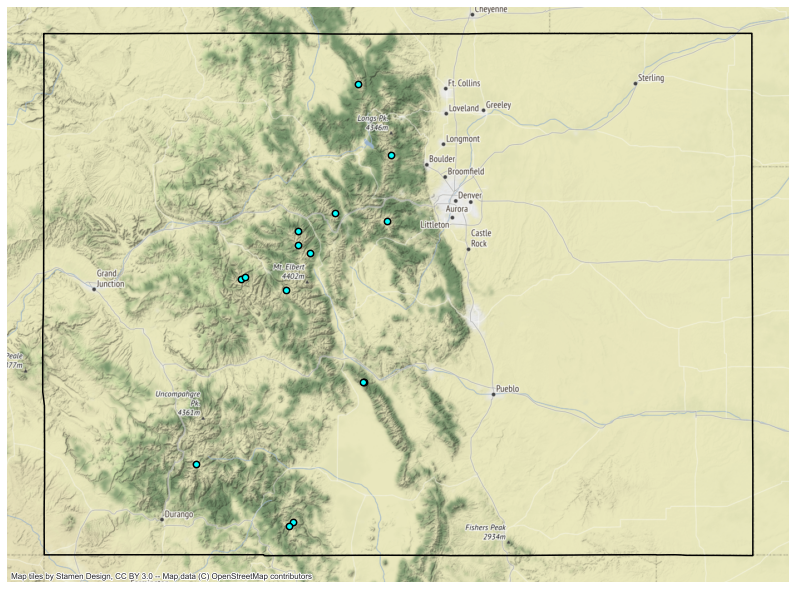

In [5]:
# Convert lake coordinates and state borders to share basemap crs
lake_coords_projected = lake_coords.to_crs(epsg=3857)
states_projected = state_bounds.to_crs(epsg=3857)

# Add a webmap basemap with contextily
fmap, axm = plt.subplots(figsize=(14, 14))
states_projected.plot(ax=axm, color='none', edgecolor='black')
lake_coords_projected.plot(ax=axm,
                           marker='o', markersize=40,
                           color='aqua', edgecolor='black')
ctx.add_basemap(axm, url=ctx.providers.Stamen.Terrain)
axm.set_axis_off()

plt.savefig(os.path.join('figures', 'co_lakes_subset_map.png'),
            format='png', bbox_inches="tight")

## There’s something in the water!
The US Forest Service water inventory survey measures ion concentrations and water quality parameters for lakes throughout the Rocky Mountains. For simplicity, I focused on 15 lakes in Colorado, and chose to look at three of the twelve types of ions surveyed. Those three ions are: calcium (Ca+2), nitrate (NO3-), and ammonium (NH4+).

*A Side Note: you may notice a gap in these data. There was a lapse in sample collection for 2012-2016. These things sometimes happen in science! Project funding may run out, a leadership transition within a lab group might occur, equipment might break down and need to be replaced, life might even be disrupted by a global pandemic! These kinds of gaps in data are unfortunate, but do not diminish the value of long-term research and datasets.*

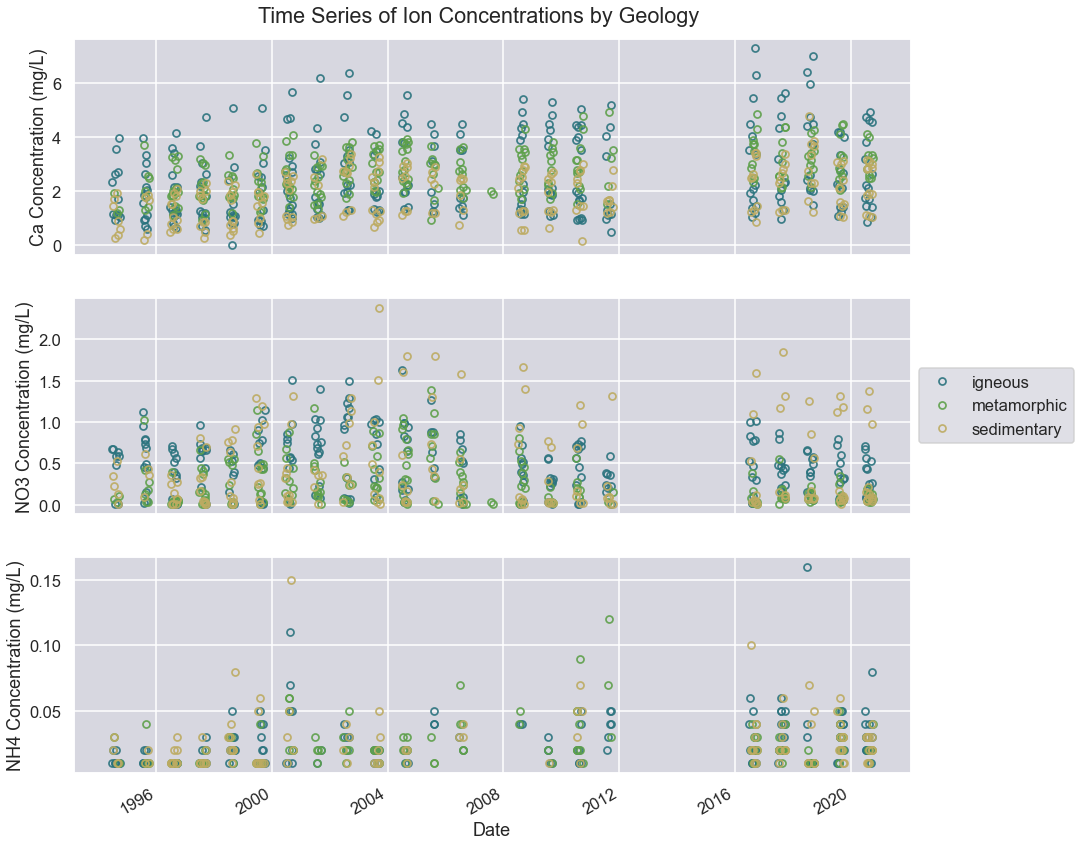

In [9]:
# Figure 1 : A Timeseries of Select Ion Concentrations grouped by Geology.
f1, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
f1.suptitle('Time Series of Ion Concentrations by Geology', y = 0.91)
params = ['Ca', 'NO3', 'NH4']
axes_flat = axes.ravel()

for ax, aparam in zip(axes_flat, params):
    flc.time_plot(lch_geo_grp, aparam, ax, color_dict_geo)
    ax.set(xlabel='Date',
           ylabel=aparam + ' Concentration (mg/L)')

plt.legend(loc='center left', bbox_to_anchor=(1, 1.7))
plt.savefig(os.path.join('figures', 'ions_by_geo.png'),
            format='png', bbox_inches="tight")
plt.show()

{Image description} A figure with three scatter plots. Dates from 1996-2021 line the x-axis. Ion concentrations are plotted on the y-axis in units of mg/L. There are three colors of points on each plot: blue representing data from lakes on igneous bedrock, green representing lakes on metamorphic bedrock, and yellow representing lakes on sedimentary bedrock.

Figure 1 : These three plots show there is little differentiation in ion concentrations based on bedrock type. 